# geometry
## for manipulating geometries

In [1]:
from gerrytools.geometry import *
from gerrytools.plotting import *
import matplotlib.pyplot as plt
import geopandas as gpd

### dual graph
This generates a graph dual to the provided geometric data (`GeoDataFrame`)

In [2]:
%%time
vtd_shp = gpd.read_file("data/NC_vtd20/") # North Carolina VTDs
graph = dualgraph(
    vtd_shp,
)

CPU times: user 14.3 s, sys: 61.9 ms, total: 14.3 s
Wall time: 14.4 s


### dissolve
This dissolves the geometric data on the column `by`. We generally use this to dissolve a set of source geometries (e.g. VTDs, blocks, etc.) to district geometries. In this case, we'll dissolve our North Carolina VTDs by county, since we don't have a district assignment column.

In [3]:
%%time
counties = dissolve(
    vtd_shp,
    by="COUNTYFP20",
    reset_index=True, # defaults to making the result integer-indexed, not the `by` column
    keep=["TOTPOP20"], # Additional columns to keep beyond the geometry and `by` columns. Defaults to []
    aggfunc="sum", # pandas groupby function type when aggregating; defaults to "sum"
)

CPU times: user 2.27 s, sys: 26 µs, total: 2.27 s
Wall time: 2.28 s


In [4]:
counties

,COUNTYFP20,geometry,TOTPOP20
0,001,"POLYGON ((1839260.022 763129.639, 1839260.412 ...",171415
1,003,"POLYGON ((1389298.082 765145.644, 1389284.038 ...",36444
2,005,"POLYGON ((1422431.302 991815.425, 1421426.874 ...",10888
3,007,"POLYGON ((1732620.327 405805.529, 1732495.878 ...",22055
4,009,"POLYGON ((1247691.922 929167.853, 1247662.879 ...",26577
...,...,...,...
95,191,"POLYGON ((2318990.659 519420.497, 2318851.097 ...",117333
96,193,"POLYGON ((1369438.820 839109.794, 1369402.328 ...",65969
97,195,"POLYGON ((2334344.508 670182.588, 2333592.386 ...",78784
98,197,"POLYGON ((1443916.015 846238.809, 1443955.597 ...",37214


/home/peter/Dropbox/MADLAB/Git_Repos/gerrytools-dev/gerrytools/plotting/choropleth.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorbarmap = plt.cm.get_cmap(cmap, len(boundaries))


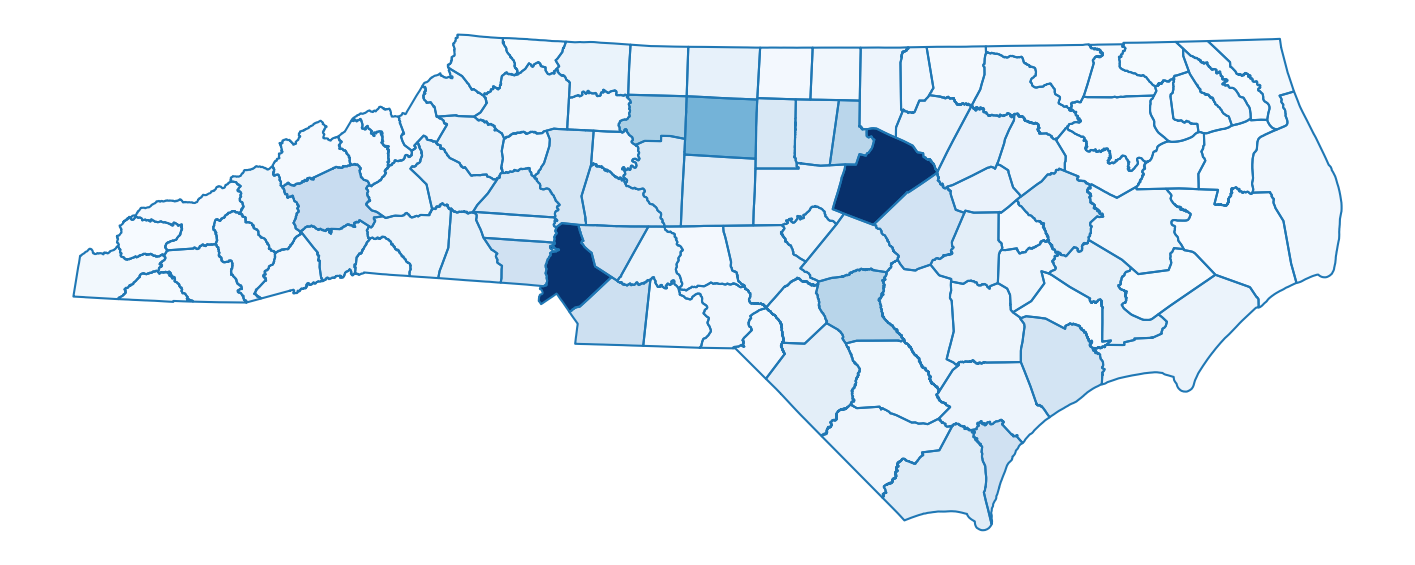

In [5]:
from gerrytools.plotting import choropleth

counties["PERCENT_OF_MAX"] = (
    counties["TOTPOP20"] / counties["TOTPOP20"].max()
)

ax = choropleth(
    geometries=counties,
    districts=counties,
    demographic_share_col="PERCENT_OF_MAX",
    cmap="Blues",
    district_linecolor="#1F77B4",
    colorbar=False,
    figsize=(18,8),
)

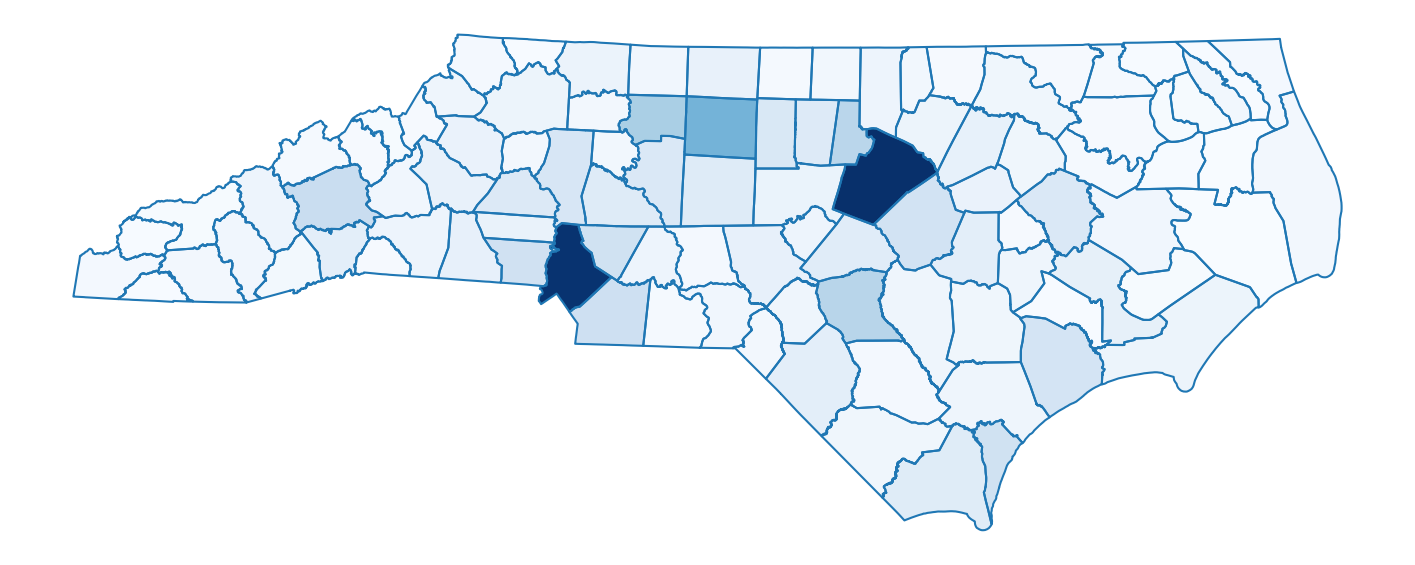

In [6]:
# show that we can now plot the county-level populations
fig, ax = plt.subplots(figsize=(18,8))
ax = counties.plot(
    ax=ax,
    column="TOTPOP20",
    cmap='Blues',
)
ax = counties.boundary.plot(ax=ax)
_ = plt.axis('off')

### unitmap and invert
`unitmap` creates a mapping from source (smaller) units to target (larger) units. `invert` inverts the provided unitmapping, mapping the target (larger) units to lists of source (smaller) units. Often we would want to do this for blocks &rarr; VTDs, but here we'll test this on VTDs &rarr; counties.

In [7]:
%%time
mapping = unitmap((vtd_shp, "GEOID20"), (counties, "COUNTYFP20"))
inverted_mapping = invert(mapping)

100%|██████████| 100/100 [00:01<00:00, 76.61it/s]

CPU times: user 1.31 s, sys: 6.67 ms, total: 1.32 s
Wall time: 1.32 s



/home/peter/Dropbox/MADLAB/Git_Repos/gerrytools-dev/.venv/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [8]:
# VTD 37025008-00 maps to county 025
mapping['37025008-00']

25.0

In [9]:
# county 025 maps to (touches) 40 VTDs, listed here...
inverted_mapping[25.0]

['37025008-00',
 '37025001-10',
 '37025001-07',
 '37025001-08',
 '37025002-08',
 '37025002-09',
 '37025003-00',
 '37025012-04',
 '37025012-03',
 '37025002-06',
 '37025002-07',
 '37025002-02',
 '37025011-01',
 '37025009-00',
 '37025004-01',
 '37025012-11',
 '37025004-08',
 '37025012-12',
 '37025012-08',
 '37025012-09',
 '37025002-03',
 '37025001-02',
 '37025001-04',
 '37025010-00',
 '37025004-03',
 '37025005-00',
 '37025012-05',
 '37025011-02',
 '37025002-05',
 '37025006-00',
 '37025012-10',
 '37025002-01',
 '37025004-09',
 '37025007-00',
 '37025012-06',
 '37025012-13',
 '37025004-12',
 '37025004-11',
 '37025004-13',
 '37025001-11']

In [10]:
mapping = unitmap((vtd_shp, "GEOID20"), (counties, "COUNTYFP20"))
inverted_mapping = invert(mapping)

print(f"mapping['37025008-00']={mapping['37025008-00']}")
print(f"inverted_mapping[25.0]={inverted_mapping[25.0]}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 78.41it/s]

mapping['37025008-00']=25.0
inverted_mapping[25.0]=['37025008-00', '37025001-10', '37025001-07', '37025001-08', '37025002-08', '37025002-09', '37025003-00', '37025012-04', '37025012-03', '37025002-06', '37025002-07', '37025002-02', '37025011-01', '37025009-00', '37025004-01', '37025012-11', '37025004-08', '37025012-12', '37025012-08', '37025012-09', '37025002-03', '37025001-02', '37025001-04', '37025010-00', '37025004-03', '37025005-00', '37025012-05', '37025011-02', '37025002-05', '37025006-00', '37025012-10', '37025002-01', '37025004-09', '37025007-00', '37025012-06', '37025012-13', '37025004-12', '37025004-11', '37025004-13', '37025001-11']



/home/peter/Dropbox/MADLAB/Git_Repos/gerrytools-dev/.venv/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


### TODO:
`dispersion_updater_closure`, `minimize_parity`, `minimize_dispersion_with_parity`